In [1]:
import numpy as np
import cv2 as cv
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq
import seaborn as sns
import anndata as ad
import umap
from sklearn.ensemble import RandomForestClassifier

Load data.
Create contrast palette.

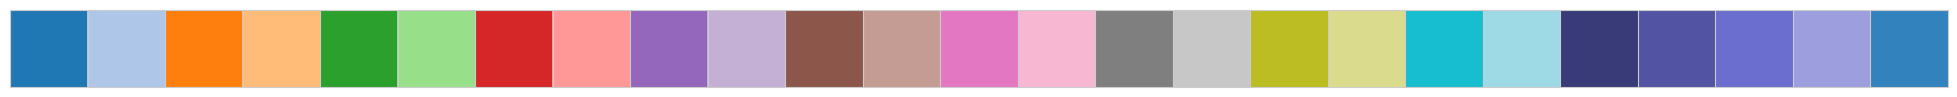

In [2]:
cmap1 = plt.get_cmap("tab20")
cmap2 = plt.get_cmap("tab20b")
cmap3 = plt.get_cmap("tab20c")
colors1 = cmap1.colors
colors2 = cmap2.colors
colors3 = cmap3.colors
contrast_palette = sns.color_palette(list(colors1) + list(colors2[:4]) + list(colors3[:1]))
del cmap1, cmap2, cmap3, colors1, colors2, colors3
sns.palplot(contrast_palette)

In [3]:
results_folder = 'results/CosMx/'
exp_df = pd.read_csv('F:/Ziqian Zheng/Spotiphy_data/CosMx/Raw_data_MsBrain/R5539_Ms2CD/R5539_Ms2CD_exprMat_file.csv')
exp_df = exp_df[exp_df['cell_ID'] != 0]
meta_df = pd.read_csv('F:/Ziqian Zheng/Spotiphy_data/CosMx/Raw_data_MsBrain/R5539_Ms2CD/R5539_Ms2CD_metadata_file.csv')
adata_cos = ad.AnnData(exp_df.iloc[:, 2:])
meta_df.index = adata_cos.obs_names
adata_cos.obs = meta_df
adata_cos_orig = adata_cos.copy()
del exp_df, meta_df
adata_st = sc.read_visium("F:/Ziqian Zheng/Spotiphy_data/ST/Sample221/outs")
adata_st.var_names_make_unique()
loc_fov = pd.read_csv('F:/Ziqian Zheng/Spotiphy_data/CosMx/Raw_data_MsBrain/R5539_Ms2CD/R5539_Ms2CD_fov_positions_file.csv', index_col=0).values

C:\Users\zzheng92\Anaconda3\envs\spotiphy\lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\zzheng92\Anaconda3\envs\spotiphy\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
adata_sc_orig = sc.read_h5ad("F:/Ziqian Zheng/Spatial omics/Public dataset/scRNA/scRNA.h5ad")
type_list = sorted(list(np.unique(adata_sc_orig.obs['Allen.subclass_label'])))
n_type = len(type_list)
adata_st.uns['type_list'] = type_list

In [5]:
# marker_df = pd.read_excel('F:/Ziqian Zheng/Spotiphy_data/CosMx/CosMx_marker.xlsx')
# marker_df = marker_df[marker_df['marker']=='+']
# marker_gene = list(marker_df['gene'])
marker_df = pd.read_csv(results_folder+'marker_gene.csv', index_col=0)
marker_df = marker_df[marker_df['gene'].isin(adata_cos_orig.var_names)]
marker_gene = marker_df['gene'].values

In [6]:
adata_sc = adata_sc_orig.copy()
adata_cos = adata_cos_orig.copy()
# common_gene = list(set(adata_cos.var_names) & set(adata_sc.var_names))
common_gene = marker_gene
adata_sc = adata_sc[:, common_gene]
adata_cos = adata_cos[:, common_gene]

Cell type analysis

In [7]:
X_orig = adata_sc.X.toarray()
X_cos_orig = adata_cos.X.toarray()
X_combined = np.vstack((X_orig, X_cos_orig))
y_orig = adata_sc.obs['Allen.subclass_label'].to_numpy()
X = 1000*X_combined/(np.sum(X_combined, axis=1, keepdims=True)+1e-10)
X, X_cos = X[:len(X_orig)], X[len(X_orig):]

In [8]:
# %%time
# clf = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=16, max_depth=10)
# clf.fit(X_train, y_train)
# print(np.sum(clf.predict(X_train)==y_train)/len(y_train))
# y_pred = clf.predict(X_test)
# adata_cos.obs['cell_type'] = y_pred
# adata_cos.obs['cell_type'].value_counts()

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
device = 'cuda:0'
y = np.array([type_list.index(i) for i in y_orig])
X_train, X_test, y_train, y_test = train_test_split(X+np.random.normal(0, 10, X.shape), y, test_size=0.2)
X_train = torch.tensor(X_train, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)
n_classes = len(type_list)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 32)
        self.fc2 = nn.Linear(32, n_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

for epoch in range(1000):
    optimizer.zero_grad()
    outputs = net(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        with torch.no_grad():
            test_outputs = net(X_test)
            _, test_predicted = torch.max(test_outputs, 1)
            test_accuracy = (test_predicted == y_test).float().mean()
        with torch.no_grad():
            train_outputs = net(X_train)
            _, train_predicted = torch.max(train_outputs, 1)
            train_accuracy = (train_predicted == y_train).float().mean()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Train accuracy: {train_accuracy.item()}, Test accuracy: {test_accuracy.item()}')

Epoch 100, Loss: 0.30299896001815796, Train accuracy: 0.8994287848472595, Test accuracy: 0.8997746109962463
Epoch 200, Loss: 0.1960490643978119, Train accuracy: 0.9303075671195984, Test accuracy: 0.9287592172622681
Epoch 300, Loss: 0.1687164157629013, Train accuracy: 0.9392910599708557, Test accuracy: 0.9363966584205627
Epoch 400, Loss: 0.15004007518291473, Train accuracy: 0.9464590549468994, Test accuracy: 0.9424377083778381
Epoch 500, Loss: 0.13853015005588531, Train accuracy: 0.9507943391799927, Test accuracy: 0.9452860951423645
Epoch 600, Loss: 0.12942074239253998, Train accuracy: 0.9531419277191162, Test accuracy: 0.9477901458740234
Epoch 700, Loss: 0.12208011001348495, Train accuracy: 0.9555521011352539, Test accuracy: 0.9492926001548767
Epoch 800, Loss: 0.11761745065450668, Train accuracy: 0.9572737216949463, Test accuracy: 0.9510767459869385
Epoch 900, Loss: 0.11464250087738037, Train accuracy: 0.958275318145752, Test accuracy: 0.9512958526611328
Epoch 1000, Loss: 0.11237037181

In [48]:
outputs = net(torch.tensor(X_cos, dtype=torch.float).to(device))
_, predicted = torch.max(outputs, 1)
y_pred = np.array(type_list)[predicted.cpu().numpy()]
adata_cos.obs['cell_type'] = y_pred
adata_cos.obs['cell_type'].value_counts()

cell_type
L6 CT         5144
Pvalb         1544
L2/3 IT       1468
Macrophage    1442
Oligo         1428
L6b           1372
L5 ET         1350
L5/6 NP       1079
Lamp5          639
VLMC           603
Astro          535
Vip            435
Prog/IP        362
Peri           310
Sst            277
Endo           239
L5 IT          200
L6 IT          108
OPC             71
Sncg            54
CR              48
SMC             44
Name: count, dtype: int64

In [50]:
summary_df = pd.DataFrame({'fov':np.arange(1, 21), 'x':loc_fov[:, 0], 'y':loc_fov[:, 1]})
summary_df[type_list] = 0
for fov, cell_type in zip(adata_cos.obs['fov'], adata_cos.obs['cell_type']):
    summary_df.at[fov-1, cell_type] += 1
summary_df.to_csv(results_folder+'CosMx_annotation_summary.csv')

In [44]:
type_list_cos = list(sorted(adata_cos.obs['cell_type'].unique()))
X_cos_sort = X_cos[np.argsort(y_pred)]
X_sort = X[np.argsort(y)]

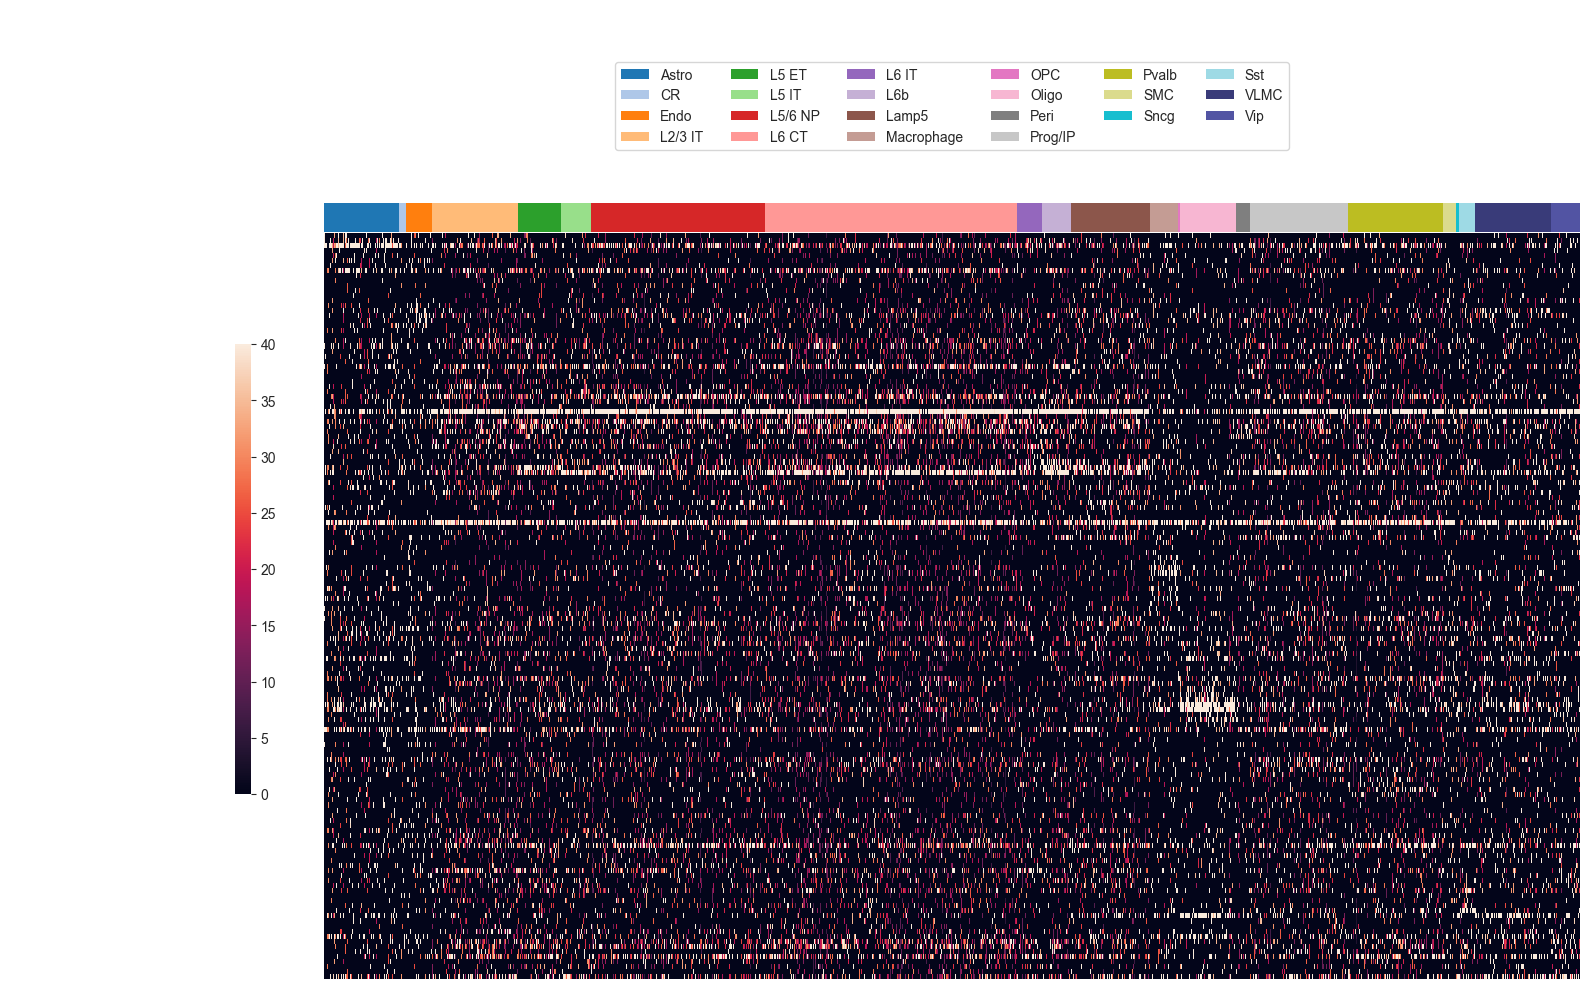

In [45]:
palette_dict = dict(zip(map(str, type_list), contrast_palette))
col_colors = adata_cos.obs['cell_type'].sort_values().map(palette_dict).to_numpy()
g = sns.clustermap(X_cos_sort.T, vmax=40, row_cluster=False, col_cluster=False, xticklabels=False, yticklabels=False,
                   figsize=(16, 10), col_colors=col_colors)
for label in type_list:
    g.ax_col_dendrogram.bar(0, 0, color=palette_dict[label], label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)
g.cax.set_position([.15, .2, .01, .45])

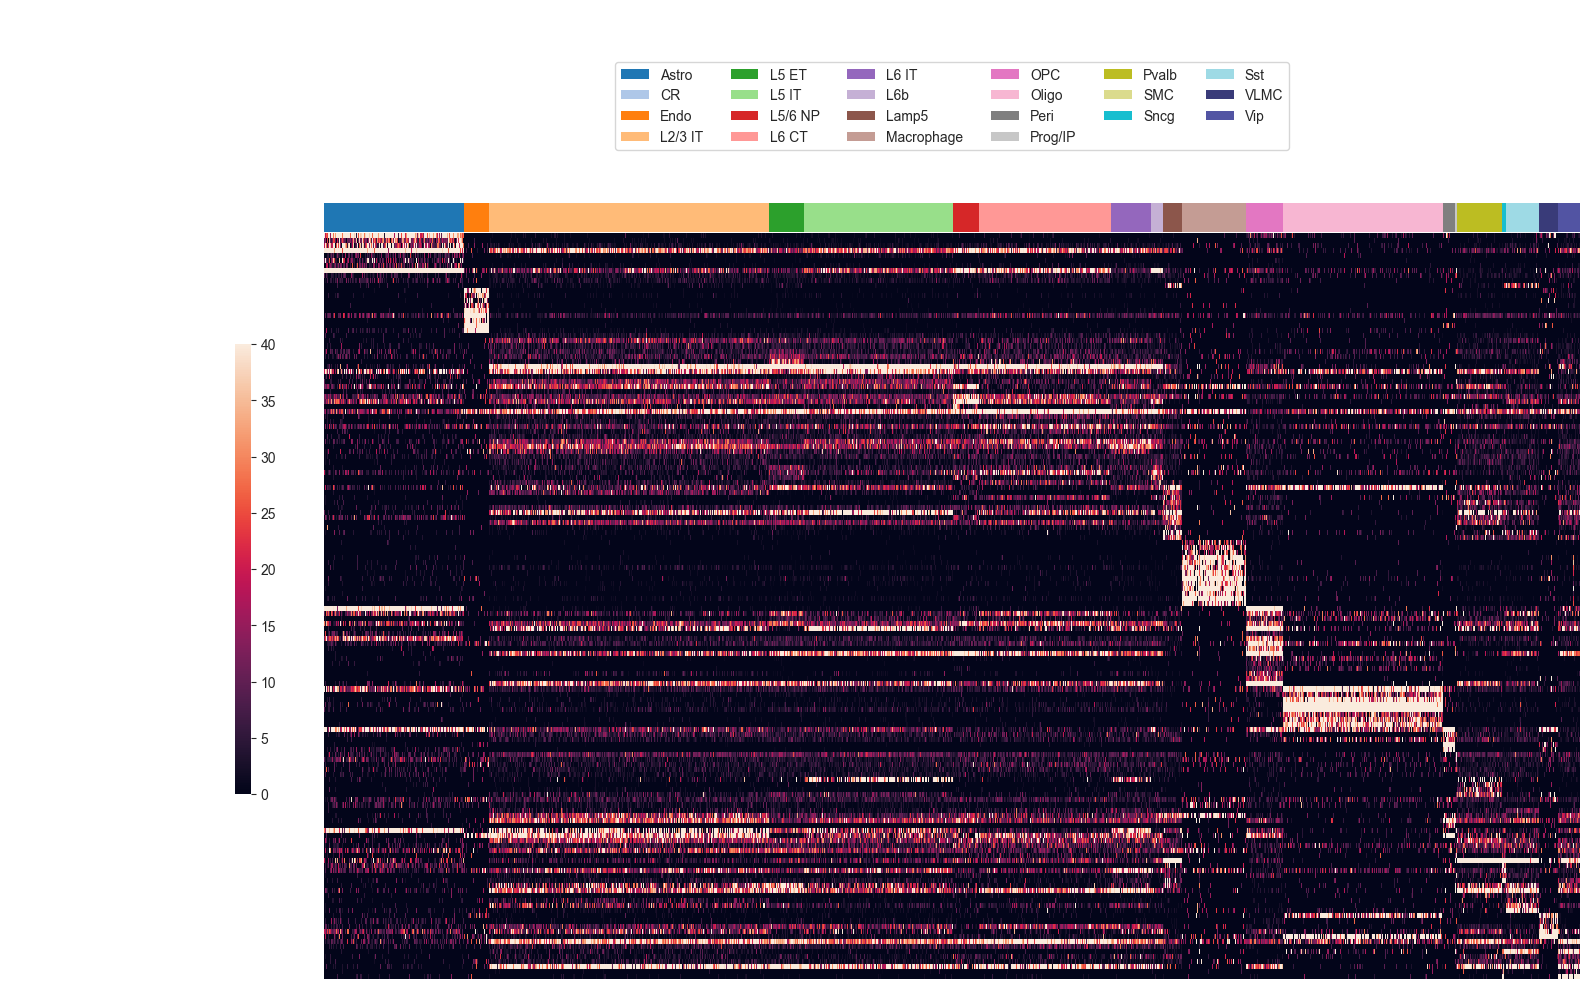

In [26]:
col_colors = adata_sc.obs['Allen.subclass_label'].sort_values().map(palette_dict).to_numpy()
g = sns.clustermap(X_sort.T, vmax=40, row_cluster=False, col_cluster=False, xticklabels=False, yticklabels=False,
                   figsize=(16, 10), col_colors=col_colors)
for label in type_list:
    g.ax_col_dendrogram.bar(0, 0, color=palette_dict[label], label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)
g.cax.set_position([.15, .2, .01, .45])

In [8]:
# adata_sc_copy = adata_sc.copy()
# adata_sc_copy = ad.concat((adata_sc_copy, adata_sc_copy[:len(adata_cos)]))
# adata_sc_copy.obs.iloc[-len(adata_cos):, adata_sc_copy.obs.columns.get_loc('Allen.subclass_label')] = 'CosMx'
# adata_sc_copy.X[-len(adata_cos):] = adata_cos.X
# sc.pp.normalize_total(adata_sc_copy, target_sum=1e4)
# sc.pp.log1p(adata_sc_copy)
# sc.pp.neighbors(adata_sc_copy, n_neighbors=10, n_pcs=40)
# sc.tl.umap(adata_sc_copy)
# with mpl.rc_context({'figure.figsize': [10, 10], 'figure.dpi': 400}):
#     ax = sc.pl.umap(adata_sc_copy, color='Allen.subclass_label', size=25, palette=contrast_palette, show=False)
#     ax.get_figure().savefig(results_folder+'umap.jpg', bbox_inches='tight')

C:\Users\zzheng92\Anaconda3\envs\spotiphy\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\zzheng92\Anaconda3\envs\spotiphy\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [20]:
loc_st = adata_st.obsm["spatial"]
loc_fov = loc_fov[:, [1, 0]]
shift = np.min(loc_fov-100, axis=0)
loc_fov -= shift
n_fov = len(loc_fov)
loc_nucleus = adata_cos.obs[['CenterY_global_px', 'CenterX_global_px']].values
loc_nucleus -= shift
adata_cos = adata_cos[loc_nucleus[:,1]<15000]
loc_nucleus = loc_nucleus[loc_nucleus[:,1]<15000]

In [21]:
img_list = []
for i in range(1, n_fov+1):
    name = '0'+str(i) if i<10 else str(i)
    img = cv.imread(f'F:/Ziqian Zheng/Spotiphy_data/CosMx/Raw_data_MsBrain/R5539_Ms2CD/MsBrain2_Cell Overlay/CellOverlay_F0{name}.jpg')
    img_list.append(img)
del img
img_size = img_list[0].shape[:2]

In [22]:
%%time
img_full = np.ones((33000, 69000, 3))*255
for i in range(n_fov):
    loc = loc_fov[i].astype(np.int32)
    img_full[loc[0]:loc[0]+img_size[0], loc[1]:loc[1]+img_size[1]] = img_list[i]
del img_list
img_full = img_full[:, :15000]
cv.imwrite(results_folder+'full_image.jpg', img_full)
img_full = img_full[:, :, [2, 1, 0]]

CPU times: total: 1min 6s
Wall time: 1min 6s


In [23]:
HE = cv.imread('F:/Ziqian Zheng/Spotiphy_data/ST/Sample221/Sample221.jpg')
HE = HE[:, :, [2, 1, 0]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


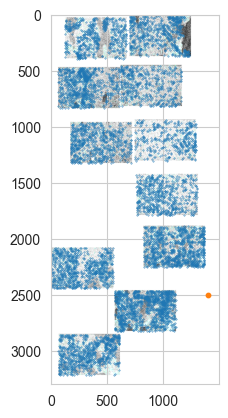

In [24]:
plt.imshow(img_full[::10, ::10])
plt.scatter(loc_nucleus[:, 1]/10, loc_nucleus[:, 0]/10, s=0.1)
plt.scatter(1400, 2500, s=10)

Visium pixel size 55/73.06=0.7528 microns.
CoxMX pixel size 600/3648=0.1644 micros.

In [25]:
ratio = 0.7528/0.1644
HE_resize = cv.resize(HE, None, fx=ratio, fy=ratio, interpolation=cv.INTER_CUBIC)
rows, cols = HE_resize.shape[:2]

In [26]:
%%time
theta = 3.2
trans = np.array([28000, 23850])
M = np.float32([[np.cos(theta), -np.sin(theta), trans[0]], [np.sin(theta), np.cos(theta), trans[1]]])
img_full_1, img_full_2 = img_full[:15000]/255, img_full[15000:]/255
M1 = M.copy()
M1[:, 2] = M1[:, 2] + M @ np.array([0, 15000, 0])
Cos_affine_1, Cos_affine_2 = cv.warpAffine(img_full_1, M, (cols, rows)), cv.warpAffine(img_full_2, M1, (cols, rows))
Cos_affine = Cos_affine_1 + Cos_affine_2
del Cos_affine_1, Cos_affine_2, img_full_1, img_full_2

CPU times: total: 20min
Wall time: 1min 18s


CPU times: total: 34.1 s
Wall time: 34.1 s


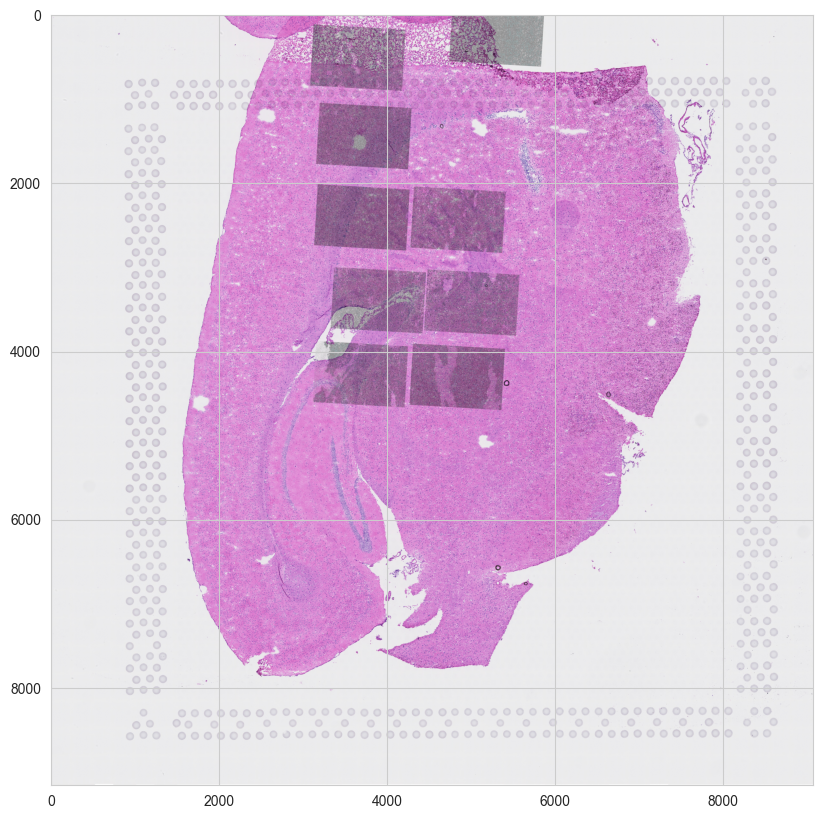

In [27]:
%%time
Cos_affine_sum = np.sum(Cos_affine[::5, ::5], axis=2)
combined_image = HE_resize[::5, ::5]*0.6 + Cos_affine[::5, ::5]*255*0.4
combined_image[Cos_affine_sum<3/255] = HE_resize[::5, ::5][Cos_affine_sum<3/255]
combined_image[Cos_affine_sum>3-3/255] = HE_resize[::5, ::5][Cos_affine_sum>3-3/255]
combined_image = combined_image/255
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(combined_image, alpha=1)
plt.savefig(results_folder+'overlay.jpg', dpi=1000)
del combined_image, Cos_affine_sum

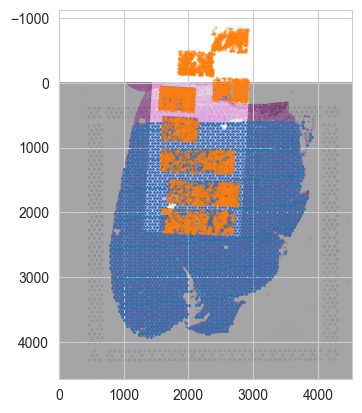

In [28]:
loc_nucleus_affine = loc_nucleus @ M[:, :2] + trans[[1, 0]]
loc_st_resize = loc_st * ratio
plt.imshow(HE_resize[::10, ::10])
plt.imshow(Cos_affine[::10, ::10], alpha=0.3)
plt.scatter(loc_st_resize[:, 0]/10, loc_st_resize[:, 1]/10, s=1)
plt.scatter(loc_nucleus_affine[:, 1]/10, loc_nucleus_affine[:, 0]/10, s=0.1)

In [34]:
Cos_annotation = np.zeros((40000, 20000, 3))
for loc, cell_type in zip(loc_nucleus_affine, adata_cos.obs['cell_type'].values):
    color = palette_dict[cell_type]
    color = np.array(color)[[2, 1, 0]]
    loc = loc[[1,0]].astype(np.int32) + np.array([-10000, 10000])
    cv.circle(Cos_annotation, loc, 40, color, -1)
cv.imwrite(results_folder+'CosMX_annotation.png', Cos_annotation*255)

In [35]:
# palette_dict = dict(zip(map(str, type_list), contrast_palette))
# col_colors = adata_cos.obs['cell_type'].map(palette_dict).to_numpy()
cell_type_df = pd.DataFrame({'x':loc_nucleus_affine[:, 1], 'y':-loc_nucleus_affine[:, 0],
                             'cell_type':adata_cos.obs['cell_type']})
plt.figure(figsize=(3, 8))
ax = sns.scatterplot(data = cell_type_df, x='x', y='y', hue='cell_type', s=1, palette=contrast_palette,
                     linewidth=0, hue_order=type_list)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(results_folder+'cell_type.jpg', dpi=2000)